In [1]:
from model import *
from loader import train_loader, validation_loader, test_loader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = UNet(input_shape=(512,512,1))
if torch.cuda.is_available():
    model = model.to('cuda')

In [3]:
# Using Adam as our optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # weight_decay=

In [4]:
criterion = nn.BCELoss()
train_hist, val_hist = None, None

In [5]:
# Initialize weights randomly (prevents getting caught at starting loss and not moving)
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

model.apply(init_weights)
print("Weights initialized")

Weights initialized


In [6]:
def train(model, criterion, epochs = 5, verbose=False, train_hist=None, val_hist=None):
  if not train_hist:
    train_hist = []
  if not val_hist:
    val_hist = []

  print("====== Training Started ======")
  for e in range(epochs):
    train_running_loss = 0.0
    validation_running_loss = 0.0
    ct = 0.0
    
    model.train()
    
    # print("Losses are reset to:", train_running_loss, validation_running_loss, ct)
    for ith_batch, sample in enumerate(train_loader):
      X, Y = sample['image'], sample['annotation']
    #   plt.imshow(pred.detach().numpy()[0].transpose(1, 2, 0))

      if torch.cuda.is_available():
        X = X.to('cuda')
        Y = Y.to('cuda')

      optimizer.zero_grad()
      y_pred = model(X)
    # out = (y_pred + 0.5).int().float()
      
      loss = criterion(y_pred, Y) #* 0.70 + 0.30 * dice_loss(y_pred, y_train)
      loss.backward()
      optimizer.step()
      
      if verbose and ith_batch % 10 == 0 and ith_batch != 0:
        # print("This item's loss:", f'{loss.item()}')
        # print("This pred started with", y_pred[0][0][0][0:10])
        print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Curr Epoch Loss: ', f'{train_running_loss / ct:0.3f}')
        
      train_running_loss += loss.item()
      train_hist.append(loss.item())
      ct += 1.0
      
    with torch.no_grad():
      
      model.eval()
      
      for ith_batch, sample in enumerate(validation_loader):
          X_val, y_val = sample['image'], sample['annotation']
          
          if torch.cuda.is_available():
            X_val = X_val.to('cuda')
            y_val = y_val.to('cuda')
          
          y_out = model(X_val)
          
          val_loss = criterion(y_out, y_val)

          validation_running_loss += val_loss.item()
          val_hist.append(val_loss.item())

    train_epoch_loss = train_running_loss / len(train_loader)
    validation_epoch_loss = validation_running_loss / len(validation_loader)
      
    if verbose:
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))
      print("Average train loss is {:0.3f}: ".format(train_epoch_loss))
      print("Average validation loss is {:0.3f}".format(validation_epoch_loss))
      print("================================================================================")
    else:
      print(f"Epoch {e + 1}. Train Loss: {train_epoch_loss:0.3f} Val Loss: {validation_epoch_loss:0.3f}")
      # Get the mask prediction in the center of the image
      # start = 512 // 2 - 3
      # end = 512 // 2 + 3
      # print(start, end)
      # print("Last pred contained", y_pred[0][0][start:end][start:end].shape)
    
    torch.cuda.empty_cache()
  return train_hist, val_hist

In [7]:
total_epochs=0

In [8]:
num_epochs = 50
# Including train_hist, val_hist in our parameters allows us to retain our previously saved loss data 
# and visualize the full training graph
train_hist, val_hist = train(model, criterion, epochs=num_epochs, verbose=False, train_hist=train_hist, val_hist=val_hist)
total_epochs+=num_epochs

====== Training Started ======
Epoch 1. Train Loss: 0.689 Val Loss: 0.693
Epoch 2. Train Loss: 0.672 Val Loss: 0.668
Epoch 3. Train Loss: 0.663 Val Loss: 0.658
Epoch 4. Train Loss: 0.659 Val Loss: 0.671
Epoch 5. Train Loss: 0.656 Val Loss: 0.657
Epoch 6. Train Loss: 0.651 Val Loss: 0.657
Epoch 7. Train Loss: 0.649 Val Loss: 0.654
Epoch 8. Train Loss: 0.648 Val Loss: 0.650
Epoch 9. Train Loss: 0.648 Val Loss: 0.652
Epoch 10. Train Loss: 0.646 Val Loss: 0.650
Epoch 11. Train Loss: 0.642 Val Loss: 0.665
Epoch 12. Train Loss: 0.641 Val Loss: 0.649
Epoch 13. Train Loss: 0.641 Val Loss: 0.640
Epoch 14. Train Loss: 0.638 Val Loss: 0.641
Epoch 15. Train Loss: 0.637 Val Loss: 0.638
Epoch 16. Train Loss: 0.630 Val Loss: 0.636
Epoch 17. Train Loss: 0.627 Val Loss: 0.630
Epoch 18. Train Loss: 0.624 Val Loss: 0.631
Epoch 19. Train Loss: 0.625 Val Loss: 0.626
Epoch 20. Train Loss: 0.620 Val Loss: 0.620
Epoch 21. Train Loss: 0.618 Val Loss: 0.621
Epoch 22. Train Loss: 0.632 Val Loss: 0.634
Epoch 23. 

In [9]:
def plot_loss(title="Without Data Augmentation", ylabel="BCE Loss", xlabel="Epochs"):
    train_means, val_means = [], []
    for i in range(total_epochs):
        train_means.append(np.mean(train_hist[len(train_loader)*i:len(train_loader)*(i+1)]))
        val_means.append(np.mean(val_hist[len(validation_loader)*i:len(validation_loader)*(i+1)]))
    plt.plot(train_means, label = 'Train Loss')
    plt.plot(val_means, label = 'Validation Loss')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()

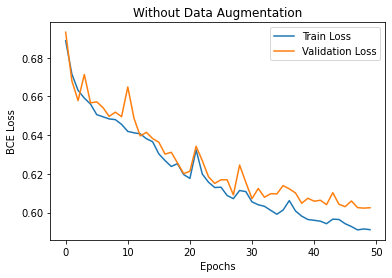

In [10]:
plot_loss()

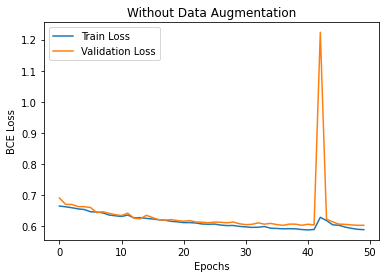

In [ ]:
# plot_loss()

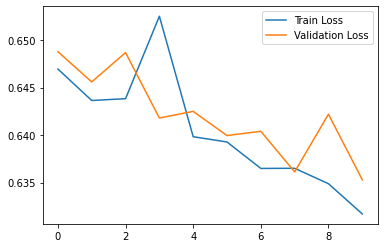

In [ ]:
# plot_loss()